In [1]:
#!nvidia-smi

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [2]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 50,
    "validation_file" : 15,
    "test_file" : 15,
    "input_size" : 50,
    "output_size" : 1,
    "init_learning_rate" : 1e-2,
    "scheduler_factor": 0.6,
    "scheduler_patience": 5,
    "scheduler_min_lr": 5e-4,
    "epoch" : 10,
    "model_name" : "LSTM2",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
tickers = list(map(str.strip,open("tickers.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/296682 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/64608 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/91813 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


In [4]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 1024
        self.batch_size = configs["batch_size"]
        self.h0 = torch.zeros((2,self.batch_size,self.hidden_size)).to(device)
        self.c0 = torch.zeros((2,self.batch_size,self.hidden_size)).to(device)
        self.layer1 = nn.LSTM(1,self.hidden_size,2,dropout=0.2,batch_first=True)
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_size,128),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(128,1)

    def forward(self, input) :
        h1,(hn,cn) = self.layer1(input,(self.h0,self.c0))
        h2 = self.layer2(h1[:,-1,:])
        output = self.layer3(h2)
        return output


In [26]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              12,603,392
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       131,200
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            129
Total params: 12,734,721
Trainable params: 12,734,721
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              12,603,392
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       131,200
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            129
Total params: 12,734,721
Trainable params: 12,734,721
Non-trainable params: 0

In [12]:
loss_fn = torch.nn.L1Loss()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


NameError: name 'model' is not defined

In [32]:
train_losses = []
val_losses = []
model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016268097573925777
val loss :  0.013543832692780398


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016291676818703613
val loss :  0.012619610394564003


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.0163004113675992
val loss :  0.013166177984662901


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.01628198956389463
val loss :  0.012688510964353193


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016290977520057585
val loss :  0.01283024232815053


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016280790734001332
val loss :  0.012631292787792485


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016288584317253142
val loss :  0.012679644965759988


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.016293054839371945
val loss :  0.012928150748478667


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.0162123630534754
val loss :  0.01270299232847973


  0%|          | 0/2161 [00:00<?, ?it/s]

  0%|          | 0/955 [00:00<?, ?it/s]

train loss :  0.01620636124258723
val loss :  0.01266559507635342


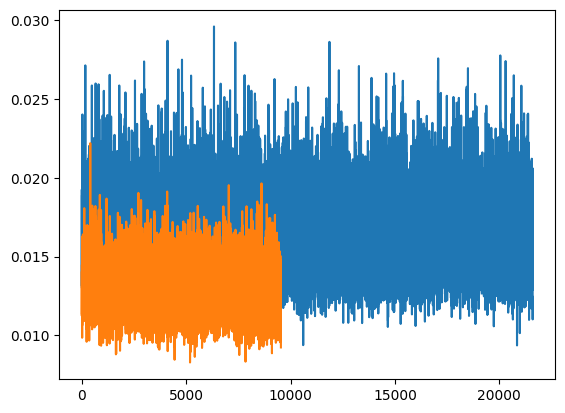

In [33]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [35]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [13]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/718 [00:00<?, ?it/s]

0.013961459273625701
